**ID: A1805**

**Submission Date: February 10, 2019**

# Kaggle House Price Assignment

## Abstract

The 'House Price' challange is one of the bignner level machine learning and data analytics competitions on Kaggle. The goal here is to predict the possible sale price of house in Ames,Iowa based on informations such as the size of the house, condition of it, how new it is, etc. Here I have firstly tried to explore the data provided to us to determine what it is that I am actually working with and then make the data usable for machine learning algorithms. This is a regression problem, as such I have tried a total of four algorithms for it -
1. Linear Regression
2. Support Vector Machine Regression(SVR)
3. XGBoost
4. Atrificial Neural Network

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
import tensorflow as tf

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Data Overview

In [44]:
print("Train Dataset: ", len(train))
print("Test Dataset: ", len(test))
print("Total attributes (Including Id and SalePrice): " ,len(train.loc[2]))

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

print("Quantitative attributes: ",len(quantitative))
print("Qualitative attributes: ", len(qualitative))

Train Dataset:  1460
Test Dataset:  1459
Total attributes (Including Id and SalePrice):  81
Quantitative attributes:  36
Qualitative attributes:  43


**concatenated both datasets to conduct data preprocessing
Here I have excluded 'Id' and 'SalePrice' columns**

In [ ]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# Data preprocessing

Below are the steps I have taken to preprocess the data.

    First I'll remove columns with high percentage of missing values(NaN).
    
    Next I'll replace the remaining numerical missing values with the mean of their respective columns
    
    Then I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normalized
    
    Lastly, I'll one hot encode the categorical data

**Visualizing how much missing data there is**

---

Here the calculation is done only using train data and the preprocessing in done on the concatenated dataset

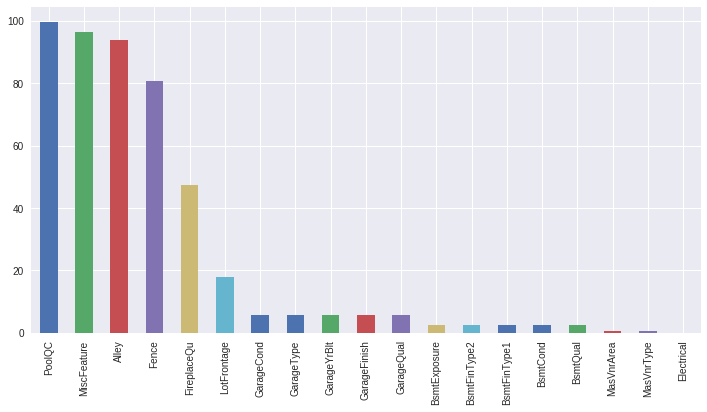

In [46]:
missing = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()*100/train.isnull().count()).sort_values(ascending=False)
missing = missing[missing > 0]
percent = percent[percent > 0]
missing_data = pd.concat([missing, percent], axis=1, keys=['Missing', 'Percent'])
percent.plot.bar()

In [47]:
missing_data.head()

,Missing,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274


## Removing all the columns with more than 50% missing value

From the graph above, we can see that 'PoolQC', 'MscFeature', 'Alley' and 'Fence' has more than 50% or rather more that 80% missing values. Even if we fill up the missing data for there features, they would be very much random in nature and won't help with creating a better model. As such I have decided to discard them al together.

In [ ]:
all_data = all_data.drop((missing_data[missing_data['Percent'] > 50]).index,1)

## Comparing current state of SalePrice with log transformed/ normal distributed values

Normal distibuted values are helpful for a better predictive model. The graph on the below right shows the of SalePrice as we have recieved from Kaggle. The graph on the left shows the distribution when SalePrice is log transformed. The code cell after the graph log transforms the SalePrice column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1936a7ab00>,
      dtype=object)

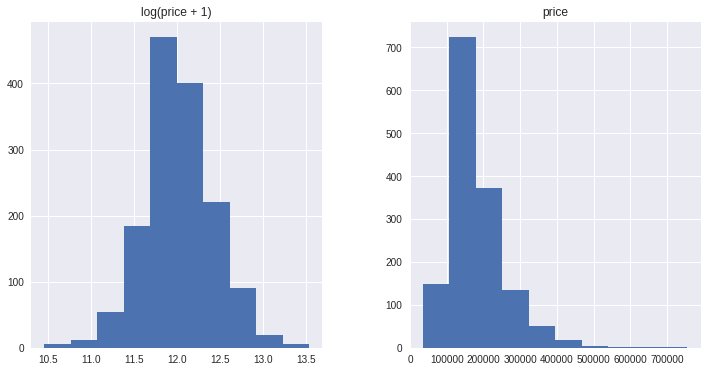

In [49]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

## Log transform of SalePrice:
    Here log1p Calculates log(1 + x), x being SalePrice.

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])

## Filling the remaining missing values with the mean of the column:

Even after discarding 4 columns/attributes, there are still some missing values remaining. The following code fills up those missing values with the mean value of each particular column

In [ ]:
all_data = all_data.fillna(all_data.mean())

## Log Transform of skewed numeric data:

Here I have first calculated the skewness of the dataset. Then I have log transformed all the data with a skewness greater than 0.75.

In [ ]:
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index #selecting numeric features

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna())) #computing skewness
skewed_features = skewed_features[skewed_features > 0.75] #selecting features with skewness greater than 0.75
skewed_features = skewed_features.index

all_data[skewed_features] = np.log1p(all_data[skewed_features])

## One hot encoding categorical data

In [ ]:
all_data = pd.get_dummies(all_data)

## Create the matrices to fit models

In [ ]:
X_all = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_all = train.SalePrice

X_y_all = X_all.assign(SalePrice=np.expm1(y_all.values))

## Splitting the dataset into train and validation sets

In [ ]:
X_train, X_val , y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=50)

# Predictive Models
I have worked with 4 predictive models here,

1.   Linear Regression
2.   Support Vector Machine(SVM)
3.   XGBoost
4.   Artificial Neural Network

## Linear Regression

In [ ]:
linear_clf = LinearRegression()
linear_clf.fit(X_train, y_train)

print("Linear Regression Train Score: ", linear_clf.score(X_train,y_train))
print("Linear Regression Validation Score: ", linear_clf.score(X_val,y_val))

Linear Regression Train Score:  0.9542940278597263
Linear Regression Validation Score:  0.8771450857143969


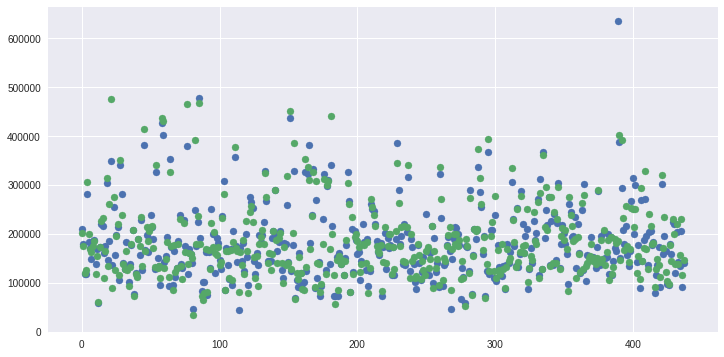

In [ ]:
pred_l = linear_clf.predict(X_val)
plt.scatter(range(len(pred_l)),np.expm1(pred_l))
plt.scatter(range(len(y_val)), np.expm1(y_val))

**The graph above demonstrats what the model predicted vs the actual validation set results. We can see that the model is pretty accurate in it's prediction**

In [ ]:
# expm1 calculates exp(x) - 1 for all elements in the array.

linear_clf.fit(X_all, y_all)
linear_predictions = np.expm1(linear_clf.predict(X_test))

solution = pd.DataFrame({"Id": test.Id, "SalePrice": linear_predictions})
solution.to_csv("linear_sol_w_all.csv", index = False)

## Support Vector Machine

In [ ]:
svm_clf = SVR(C=1.0,epsilon=0.01,gamma='auto')
svm_clf.fit(X_train, y_train)

print("SVM Train Score: ", svm_clf.score(X_train,y_train))
print("SVM Validation Score: ", svm_clf.score(X_val,y_val))

SVM Train Score:  0.9809502243348687
SVM Validation Score:  0.5723518749961292


### SVM Hyper Parameter Tuning
| Degree | epsilon | C | Train Score | Validation Score |
| --- |---|---| ---|---|
| default | default | default | 0.94 | 0.56 |
| 2 | default | default | 0.94 | 0.56 |
| 3 | default | default | 0.94 | 0.56 |
| 4 | default | default | 0.94 | 0.56 |
| 2 | 0.01 | default | 0.98 | 0.57 |
| 3 | 0.01 | default | 0.98 | 0.57 |
| 4 | 0.01 | default | 0.98 | 0.57 |
| default | 0.001 | 0.9 | 0.97 | 0.57 |
| default | 0.001 | 0.9 | 0.97 | 0.57 |
| default | 0.001 | 0.9 | 0.97 | 0.57 |
| default | 0.01 | 0.8 | 0.96 | 0.57 |
| default | 0.01 | 0.8 | 0.96 | 0.57 |
| default | 0.01 | 0.8 | 0.96 | 0.57 |
| default | 0.01 | 1.1 | 0.98 | 0.57 |
| default | 0.01 | 1.1 | 0.98 | 0.57 |

### SVM Discussion

Degree has no effect on result.

Epsilon 0.001 din't perform better than 0.01. But 0.01 performed better that 0.1, the default value

Reducing the Penalty parameter C results in a lower overall accuracy. Increasing it shows no improvement compared to default value of 1.0

In [ ]:
# expm1 calculates exp(x) - 1 for all elements in the array.

svm_clf.fit(X_all, y_all)
svm_predictions = np.expm1(svm_clf.predict(X_test))

solution = pd.DataFrame({"Id": test.Id, "SalePrice": svm_predictions})
solution.to_csv("svm_sol_w_all.csv", index = False)

## XGBoost

In [ ]:
xgboost_clf = XGBRegressor(n_estimators=2000, max_depth=2, learning_rate=0.05)
xgboost_clf.fit(X_train, y_train,verbose=False)

print("XGBoost Train Score: ", xgboost_clf.score(X_train,y_train))
print("XGBoost Validation Score: ", xgboost_clf.score(X_val,y_val))

XGBoost Train Score:  0.9861147448934361
XGBoost Validation Score:  0.8961473016983967


In [ ]:
# expm1 calculates exp(x) - 1 for all elements in the array.

xgboost_clf.fit(X_all, y_all,verbose=False)
xgboost_predictions = np.expm1(xgboost_clf.predict(X_test))

solution = pd.DataFrame({"Id": test.Id, "SalePrice": xgboost_predictions})
solution.to_csv("xgb_sol.csv", index = False)

### XGBoost Hyper Parameter Tuning
| n_estimators | max_depth | learning_rate | Train Score | Validation Score |
| --- | --- | --- | --- | --- |
| 1000 | default | 0.01 | 0.97 | 0.86 |
| 1000 | default | 0.03 | 0.98 | 0.86 |
| 1000 | default | 0.05 | 0.99 |0.86 |
| 1000 | default | 0.07 | 0.99 | 0.86 |
| 1000 | 2 | 0.05 | 0.98 | 0.87 |
| 1000 | 2 | 0.07 | 0.98 | 0.87 |
| 800 | 2 | 0.05 | 0.98 | 0.87 |
| 800 | 2 | 0.07 | 0.98 | 0.87 |
| 800 | 2 | 0.05 | 0.99 | 0.87 |
| 800 | 2 | 0.07 | 0.99 | 0.87 |
| 2000 | 2 | 0.05 | 0.99 | 0.87 |
| 2000 | 2 | 0.07 | 0.99 | 0.87 |

### XGBoost Discussion

| - | n_estimators | max_depth | learning_rate | Kaggle Submission Score |
| --- | --- | --- | --- | --- |
| Best Parameters |1000 | 2 | 0.05 | 0.13263 |

The reason n_estimators=1000 is chosen the best parameter even though setting it to 2000 gives us a better train score is because the validation score remains unchanged. This gives hint that increasing n_estimator won't neccessarily give us a better submission score.

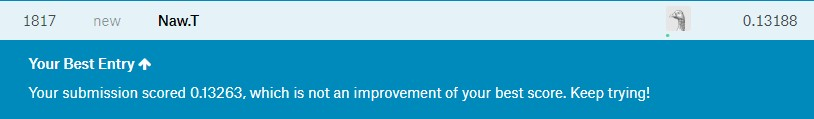

In [ ]:
from IPython.display import Image
Image("xgb_sol_sc.jpg")

## Artificial Neural Network

In [ ]:
y_train = np.expm1(y_train)

In [ ]:
# Network Information
hidden_1 = 64
hidden_2 = 32
hidden_3 = 256
input_dim = X_all.shape[1]  # Number of features
output_dim = 1              # Because it is a regression problem

X_tf = tf.placeholder("float")
y_tf = tf.placeholder("float")



*   **tf.Variable() will create a variable of which value will be changing during optimization steps**
*   **tf.random_normal() will generate random number of normal  distribution**




In [ ]:
# Weights and Bias

weights = {
    'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),
    'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),
    'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])),
    'out': tf.Variable(tf.random_normal([hidden_2, output_dim]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([hidden_1])),
    'b2': tf.Variable(tf.random_normal([hidden_2])),
    'b3': tf.Variable(tf.random_normal([hidden_3])),
    'out': tf.Variable(tf.random_normal([output_dim]))
}

In [1]:
# Model Design

def ann_model(X_val):
  # Hidden layers
  layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1'])
  layer_1 = tf.nn.relu(layer_1)
  
  layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
  layer_2 = tf.nn.relu(layer_2)
  
  layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
  layer_3 = tf.nn.relu(layer_3)
  
  # Output layer
  layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases['out'])
  
  return layer_out

In [ ]:
# Parameters
learning_rate = 0.001

# Model Construct
model = ann_model(X_tf)

# Mean Squared Error cost function
cost = tf.reduce_mean(tf.square(model - y_tf))

# Adam optimizer will update weights and biases after each step
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(cost)

In [ ]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(20000):
    sess.run(optimizer, feed_dict={X_tf:X_train, y_tf:y_train})
    if (i+1)%500 == 0:
      print('Epoch:', i+1)
    
  pred = sess.run(model, feed_dict={X_tf: X_test})

In [ ]:
solution = pd.DataFrame({"Id": test.Id, "SalePrice": pred.ravel() })
solution.to_csv("Tf_sol.csv", index = False)

### ANN Hyper Parameter Tuning

| Weight and Bias | HIdden Layer Shapes | Activation Function | Optimizer | Learning Rate | Epochs | Kaggle RMSE
| --- | --- | --- | --- | --- | --- | --- |
| Random Normal | 32-16 | Relu | Adadelta | 0.01 | 20,000 | 0.42721 |
| Random Normal | 64-32 | Relu | Adadelta | 0.01 | 2,000 | 0.74953 |
| Random Normal | 64-32 | Relu | Adadelta | 0.01 | 9,000 | 0.42444 |
| Random Normal | 64-32 | Relu | Adadelta | 0.01 | 20,000 | 0.42721 |
| Random Normal | 256-128-128| Relu | Adam+L2Regularize(0.05)| 0.01 | 100 | 0.42282 |
| Random Normal | 256-128-128| Relu | Adadelta+L2Regularize(0.05)| 0.01 | 2000 | 0.54770 |
| Random Normal | 256-128-128| Relu | Adadelta+L2Regularize(0.05)| 0.01 | 5000 | 0.68175 |
| Random Normal | 256-256 | Relu | Adam | 0.1 | 146,000 | 0.42837 |
| Random Normal | 256-256-256 | Relu | Adam | 0.1 | 146,000 | 0.60645 |
| Random Normal | 128-256-128 | Relu | Adam | 0.01 | 292,000 | 0.41890 |
| Random Normal | 256-256-256 | Relu | Adadelta | 0.01 | 2,000 | 0.43420 |
| Random Normal | 256-256-256 | Relu | Adadelta | 0.01 | 4,000 | 0.47207 |
| Random Normal | 256-256-256 | Relu | Adadelta | 0.01 | 1,000 | 0.47228 |
| Random Normal | 256-256-256 | Relu | Adadelta | 0.01 | 10,000 | 0.44661 |
| Random Normal | 256-512-256 | Relu | Adadelta | 0.01 | 2,000 | 0.52053 |
| Random Normal | 256-512-256 | Relu | Adadelta | 0.01 | 10,000 | 0.48784 |

### ANN Discussion
From the results above, we can see that the artificial neural network, which is producing a polynomial prediction model performs worse than the linear prediction model or the decision tree based prediction model. This is beacuse the house price prediction problem leans more towards being a linear problem in nature. So when we try to fit a polynomial model, it under performs.

# Acknowledgement






1. Handling Missing Values

> https://www.kaggle.com/dansbecker/handling-missing-values

2.   One hot encoding

>https://stackoverflow.com/questions/47460387/how-do-i-resolve-one-hot-encoding-if-my-test-data-has-missing-values-in-a-col

3. Comprehensive data exploration with Python

>https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

4. Regularized Linear Models

> https://www.kaggle.com/apapiu/regularized-linear-models/notebook

5. House Prices EDA

> https://www.kaggle.com/dgawlik/house-prices-eda

6. House prices: Lasso, XGBoost, and a detailed EDA

> https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda/report

